# Од чега зависи задовољство животом?
У наредном примеру ћемо демографским подацима из __[**NHANES**](https://www.cdc.gov/Nchs/Nhanes/about_nhanes.htm)__ скупа података придружити податке прикупљене различитим упитницима. У питању су резултати који нису настали објективним мерењима као што су лабораторијска анализа или физички преглед, већ на основу одговора или субјективне процене самих испитаника. Ове варијабле тичу се њиховог задовољства животом, њихових осећања, учесталости коришћења дрога и алкохола, сексуалних навика и слично.  

In [21]:
import pandas as pd

podaciUpit = pd.read_csv('podaci/questionnaire.csv')
podaciUpit.head(5)

,SEQN,HSD010,SLD010H,PAQ710,PAQ715,PAQ650,PAQ665,SXD031,SXD171,SXD101,...,DPQ090,SMQ020,SMD030,SMQ040,SMD650,ALQ101,ALQ110,ALQ120Q,ALQ120U,ALQ130
0,73557,2.0,7.0,2.0,8.0,2.0,2.0,15.0,99999.0,0.0,...,0.0,1.0,17.0,3.0,0.0,1.0,0.0,1.0,3.0,1.0
1,73558,4.0,9.0,4.0,8.0,2.0,2.0,14.0,99999.0,0.0,...,0.0,1.0,0.0,2.0,1.0,1.0,0.0,7.0,1.0,4.0
2,73559,3.0,8.0,4.0,0.0,2.0,1.0,NaN,99999.0,NaN,...,0.0,1.0,20.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
3,73560,0.0,NaN,3.0,2.0,0.0,0.0,NaN,99999.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,5.0,9.0,1.0,1.0,2.0,2.0,NaN,99999.0,NaN,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Упитнички подаци у оригиналном скупу смештени су у више од 40 табела. Овде смо издвојили само 32 варијабле из неколико табела. Детаљнији опис целог скупа можете да пронађете на страници пројекта __[NHANES](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&Cycle=2013-2014)__. Ове колоне ћемо повезати са неколико демографских варијабли: полом (RIAGENDR), узрастом (RIDAGEYR), степеном образовања (DMDEDUC2), брачни статусом (DMDMARTL) и просечним приходима (INDFMIN2).

In [22]:
podaciDem = pd.read_csv('podaci/demographic.csv')[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'DMDMARTL', 'INDFMIN2']]
podaciDemUpit = pd.merge(podaciDem, podaciUpit, on='SEQN') 

# Обрисаћемо привремене табеле да не заузимају меморијски простор
del podaciDem, podaciUpit

Између осталог, поменути упитник је садржао 9 питања којима се процењује заступљеност симптома депресије код испитаника, нпр. „Немам воље да било шта радим“, „Осећам се потиштено и безнадежно“, „Осећам се уморно“ итд. Испитаници су означавали степен слагања са сваком ставком на четворостепеној скали од 0 („Уопште не“) до 3 („Скоро свакога дана“). Код оваквих упитника уобичајено је да се вредности одговора на сва питања саберу и претворе у тзв. *сумациони скор*. На тај начин се добија мера изражености неког својства, у овом случају осећања депримираности. Испитаници који су на сва питања одговорили са 3 имаће највећи скор, односно највиши ниво показатеља депресивности. Пре сумирања ћемо искључити све испитанике који нису желели (7) или нису могли да дају одговор (9) на неко од питања, као и оне за које не постоји податак о брачном статусу (77 и 99). 

In [23]:
# Издвајамо само испитанике који су одговорили на сва питања на скали депресивности
upitDep = podaciDemUpit[(podaciDemUpit['DPQ010'].between(0,4)) & 
                        (podaciDemUpit['DPQ020'].between(0,4)) & 
                        (podaciDemUpit['DPQ030'].between(0,4)) & 
                        (podaciDemUpit['DPQ040'].between(0,4)) &
                        (podaciDemUpit['DPQ050'].between(0,4)) &
                        (podaciDemUpit['DPQ060'].between(0,4)) &
                        (podaciDemUpit['DPQ070'].between(0,4)) &
                        (podaciDemUpit['DPQ080'].between(0,4)) &
                        (podaciDemUpit['DPQ090'].between(0,4)) & 
                        # Уклањамо и испитанике код којих немамо податак о брачном статусу
                        (podaciDemUpit['DMDMARTL'] < 77) 
                       ].copy()

# Рачунамо збир одговора на сваку ставку упитника
upitDep['sumDep'] = upitDep['DPQ010'] + upitDep['DPQ020'] + upitDep['DPQ030'] + \
                    upitDep['DPQ040'] + upitDep['DPQ050'] + upitDep['DPQ060'] + \
                    upitDep['DPQ070'] + upitDep['DPQ080'] + upitDep['DPQ090'];

Након рачунања сумативног скора и смештања вредности у нову варијаблу `sumDep`, исцртавамо просеке уз помоћ линијског дијаграма. Као категоријалне варијабле употребићемо пол испитаника и њихов брачни статус да бисмо видели да ли међу њима постоји нека разлика у нивоу депресивности. 

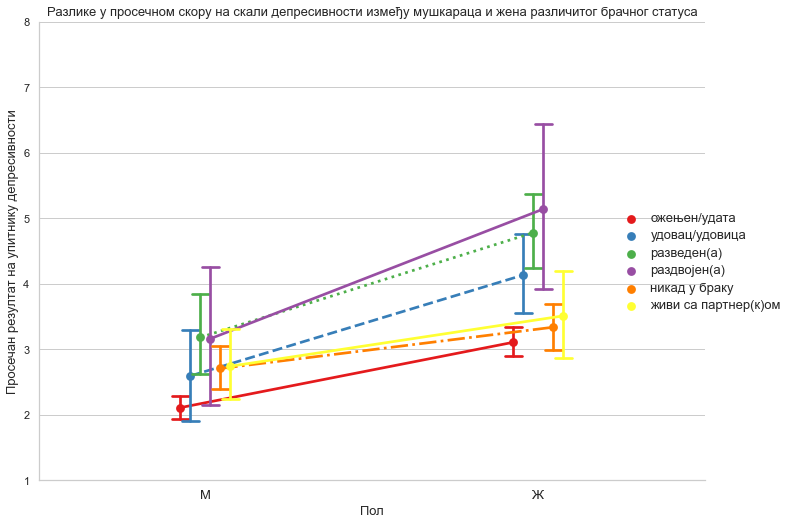

In [24]:
import seaborn as sbrn
import matplotlib.pyplot as plt

# Из скупа тема бирамо ону која ће графикон обојити у бело
sbrn.set_theme(style="whitegrid")

# На x-осу постављамо пол, а на y- сумациони скор
grafLin = sbrn.catplot(data=upitDep, x="RIAGENDR", y="sumDep", 
                      # Боја линије је дегфинисана на основу брачног статуса
                      hue="DMDMARTL", palette="Set1", 
                      # Величина "капица" на вертикалним линијама и додавање тачкица на крајевима
                      capsize=0.05,  kind="point", 
                      # Приказујемо легенду и дефинишемо однос димензија графикона
                      legend=True, aspect=1.4, height=7, 
                      # Мало ћемо "смакнути" линије по хорозонтали да се не би преклапале
                      dodge=True,
                      # Дефинишемо изглед линија (цртице, тачкице...)
                      linestyles=["-", "--", ":", "-", "-.", "-"])

# Дефинишемо распон вредности на y-оси. 
plt.ylim(1, 8) 

# Додељујемо називе категоријама брачног статуса варијабли brStatus
brStatus = ['ожењен/удата', 'удовац/удовица', 'разведен(а)', 'раздвојен(а)', 'никад у браку', 'живи са партнер(к)ом']

# За сваку категорију брачног статуса додељујемо један елемент легенде 
for rb, brSt in enumerate(brStatus):
    grafLin._legend.texts[rb].set_text(brSt)

# Легенда неће имати наслов
grafLin._legend.set_title('')

# Осе ће имати наслове
grafLin.set_xlabels('Пол', fontsize='13')
grafLin.set_ylabels('Просечан резултат на упитнику депресивности', fontsize='13')
grafLin.set_xticklabels(['М', 'Ж'], fontsize='13')

# Подешавамо величину текста у легедни
plt.setp(grafLin._legend.get_texts(), fontsize='13')

# Постављамо наслов графикона
plt.title('Разлике у просечном скору на скали депресивности између мушкараца и жена различитог брачног статуса', fontsize='13')

plt.show()

На горњем графикону тачкама су приказане просечне вредности, а вертикалним линијама процена варијабилности скорова на скали депресивности за 12 група испитаника. Групе су настале укрштањем варијабли *пол* и *брачни статус*. Хоризонталним косим линијама различите боје повезане су групе мушкараца и жена истог брачног статуса. Уочавамо да симптоме депресије најчешће испољавају особе које су разведене или раздвојене (енгл. *separated*). То су љубичасте и зелене тачке, односно линије на графикону. Најниже просечне вредности на скали депресивности имају особе које су у браку. Такође видимо да су жене генерално склоније да на упитницима испоље оваква осећања него мушкарци. Варијабилност резултата је највећа у групи раздвојених особа, без обзира на пол. Хоризонталне линије, тачније њихов нагиб, додатно олакшавају закључивање о постојању разлика међу групама. На пример, уочавамо да је разлика између мушкараца и жена мање изражена у подгрупи особа које никада нису ступале у брак, док је највећа у групама особа којима је преминуо брачни партнер, које су разведене или живе одвојено од бившег партнера. 

<div class="alert alert-block alert-info"><img src="slike/zad.png" align="left"/>Теоријски распон сумационог скора на скали депресивности је од 0 (9 · 0) до 27 (9 · 3). Промените параметре функције <b>ylim</b> у горњеm коду и поново исцртајте графикон да бисте видели у којој мери ограничавање распона на осама утиче на интерпретацију резултата. Да ли испитаници у апсолутном смислу имају високе вредности на овој варијабли? Да ли су разлике међу категоријама, насталим укрштањем пола и брачног статуса, сада толико очигледне? Да ли то значи да оне не постоје и да више нису битне?</div> 

<details>    
<summary>
    Прикажи одговор
</summary>
Разлике међу групама су мање очигледне када се прикаже цео теоријски распон варијабле. Тада се јасније види да заправо већина испитаника постиже ниске скорове на скали депресивности, а да су разлике деловале као велике јер смо посматрали само један део укупног распона. То и даље не значи да те разлике нису значајне, што би требало проверити неким статистичким тестом као што је нпр. t-тест. 

У следећем кораку анализираћемо одговоре испитаника на једноставно питање (HSD010) како генерално процењују своје здравље на скали од 1 (одлично) до 5 (веома лоше). Ову процену ћемо довести у везу са степеном образовања особе (DMDEDUC2). Пре приказивања на графикону уклонићемо кôдове за податке који нису доступни. Овога пута нећемо користити филтере као у претходним лекцијама, већ ћемо вредности 7 и 9 заменити вредношћу `pd.NA` (енгл. *Not Available*) као ознаком за недостајући податак у библиотеци `pandas`. Поред тога, рекодираћемо одговоре на питање како би ниже задовољство било означено мањим, а више већим бројем. 

In [25]:
# Недостајуће одговоре одмах мењамо вредношћу <NA>
podaciDemUpit["HSD010"].replace({0: pd.NA, 9: pd.NA, 1: 5, 2: 4, 4: 2, 5: 1}, inplace=True)

# Параметар inplace је постављен на True како би се директно изменио садржај варијабле у самом оквиру података
podaciDemUpit["DMDEDUC2"].replace({7: pd.NA, 9: pd.NA}, inplace=True)

Пре него што погледамо укрштене податке, приказаћемо дистрибуције обе варијабле. 

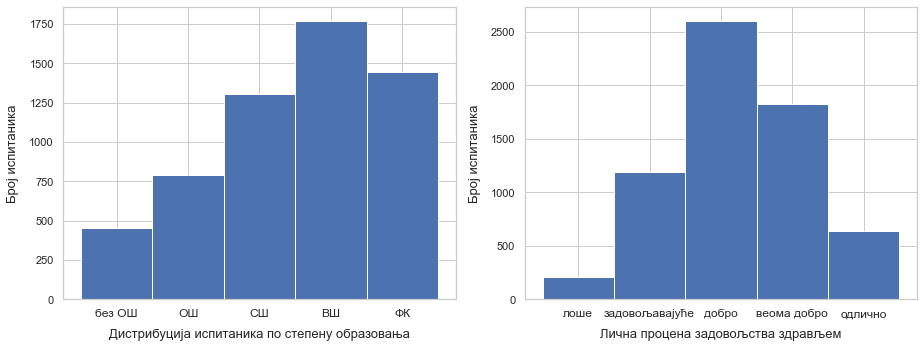

In [26]:
# Додељујемо имена категоријама образовања и субјективне процене здравља
katObrazovanje = ['без ОШ', 'ОШ', 'СШ', 'ВШ', 'ФК']
katZdravlje = ['лоше', 'задовољавајуће', 'добро', 'веома добро', 'одлично']

# Дефинишемо објекат figure која ће садржати два графикона
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

# Пребројавамо испитанике у свакој категорији и сортирамо по индексној колони (0-4)
podaciDemUpit['DMDEDUC2'].value_counts().sort_index().plot(kind='bar', width=1, edgecolor='white', ax=ax1) 
ax1.set_ylabel('Број испитаника', labelpad=10, fontsize=13)
ax1.set_xlabel('Дистрибуција испитаника по степену образовања', labelpad=10, fontsize=13)
# Називе подеока на x-оси узимамо из варијабле katObrazovanje
ax1.set_xticklabels(katObrazovanje, rotation=0, fontsize=12)

# Исто радимо и за одговор на питање о општем здравственом стању
podaciDemUpit['HSD010'].value_counts().sort_index().plot(kind='bar', width=1, edgecolor='white', ax=ax2) 
ax2.set_ylabel('Број испитаника', labelpad=10, fontsize=13)
ax2.set_xlabel('Лична процена задовољства здрављем', labelpad=10, fontsize=13)
ax2.set_xticklabels(katZdravlje, rotation=0, fontsize=12)

fig.tight_layout()

Видимо да је највише испитаника са високом школом и оних који своје опште здравствено стање процењују као добро. Сада ћемо ове податке објединити на истом графикону тако што ћемо унутар сваке групе формиране на основу нивоа образовања „наслагати“ испитанике по томе како су процењивали своје здравствено стање. Отуда и назив за ову врсту стубичастог дијаграма познатог као *stacked bar chart*. На левом графикону приказаћемо апсолутне бројеве, а на десном релативне, тачније проценте испитаника различитог здравственог статуса унутар сваке категорије образовања. 

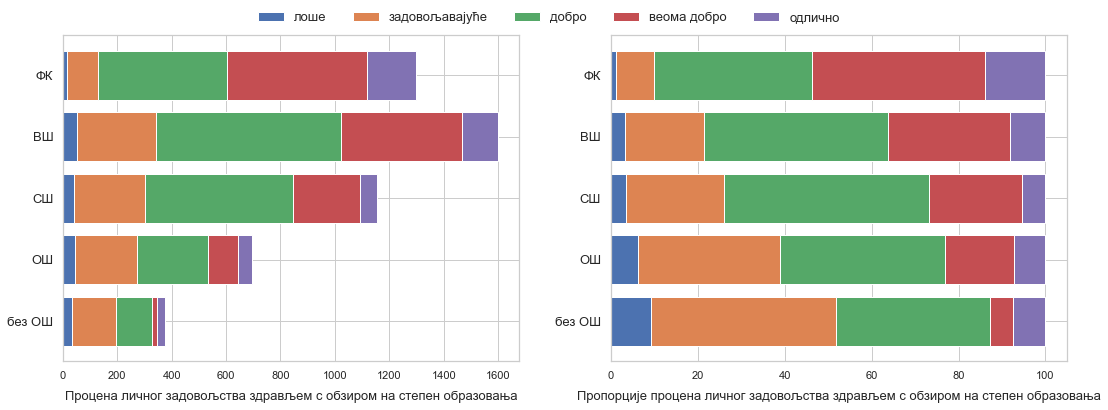

In [27]:
# Дефинишемо празан низ nivo
nivo = []
# Петљом од 1 до 5 умећемо вредности у низ
for stepOb in range(1, 6):
    # Вредности су у ствари листе пребројаних испитаника по степену образовања за сваку оцену здравственог стања (stepOb)
    nivo.append(podaciDemUpit[(podaciDemUpit['HSD010'] == stepOb) & (podaciDemUpit['RIDAGEYR'] > 18)]['DMDEDUC2'].value_counts().sort_index())

# Повезујемо (engl. concatenate) листе за сваку категорију образовања у јединствену листу svi
svi = pd.concat(nivo, axis=1)

# Додељујемо називе колонама на основу варијабле коју смо дефинисали у претходној ћелији
svi.set_axis(katZdravlje, axis=1, inplace=True)

# Правимо копију скупа svi у којој апсолутне бројеве (учесталости) претварамо у проценте
sviProc = svi.copy()
# За то нам је потребна сума учесталости свих категорја оцена здравља
sviProc['sum'] = sviProc.iloc[:,0:5].sum(axis=1)
# Учесталост сваке категорије делимо сумом свих категорија и множимо са 100
for stepOb in range(0, 5):
    sviProc.iloc[:,stepOb] = sviProc.iloc[:,stepOb] / sviProc['sum'] * 100
# Колона sum нам више није потребна
sviProc = sviProc.drop('sum', axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

# Параметар stacked је подешен на True јер желимо "наслагане" категорије 
svi.plot.barh(edgecolor='white', width=0.8, stacked=True, ax=ax1)
ax1.set_yticklabels(katObrazovanje, rotation=0, fontsize=13)
ax1.set_xlabel('Процена личног задовољства здрављем с обзиром на степен образовања', labelpad=10, fontsize=13)
# Легенду од првог графикона ћемо центрирати и искористи за оба
ax1.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.96), bbox_transform=plt.gcf().transFigure, fontsize=13, frameon=False)

sviProc.plot.barh(edgecolor='white', width=0.8, stacked=True, ax=ax2)
ax2.set_yticklabels(katObrazovanje, rotation=0, fontsize=13)
ax2.set_xlabel('Пропорције процена личног задовољства здрављем с обзиром на степен образовања', labelpad=10, fontsize=13)

# Легенда за други графикон нам није потребна
ax2.legend_.remove()

plt.show()

Графикон са леве стране је заправо раније приказани стубичасти дијаграм за степен образовања, али инвертован и ротиран за 90 степени. Поред тога, сваки стубић издељен је по категоријама формираним на основу субјективне процене личног задовољства здрављем. На десном графикону је свака трака „развучена“ тако да попуни целу ширину графикона. На тај начин смо изгубили податак о учесталостима категорија, али тек оваквим приказом пропорционалног односа категорија уочавамо тренд пораста задовљства са порастом степена образовања. То се првенствено види по ширини наранџастих и црвених трака. Наравно, то нам не даје за право да образовање посматрамо као узрок, а задовољство као последицу или обратно. Много је вероватније да се у позадини бољих могућности за образовање и позитивније перцепције здравственог стања налази неки други, можда и заједнички фактор. Уз мале модификације можемо да искористимо горњи код како бисмо проверили да ли је можда тај заједнички фактор износ укупних прихода по домаћинству. Почетних 12 категорија ћемо смањити на 6 њиховим обједињавањем. 

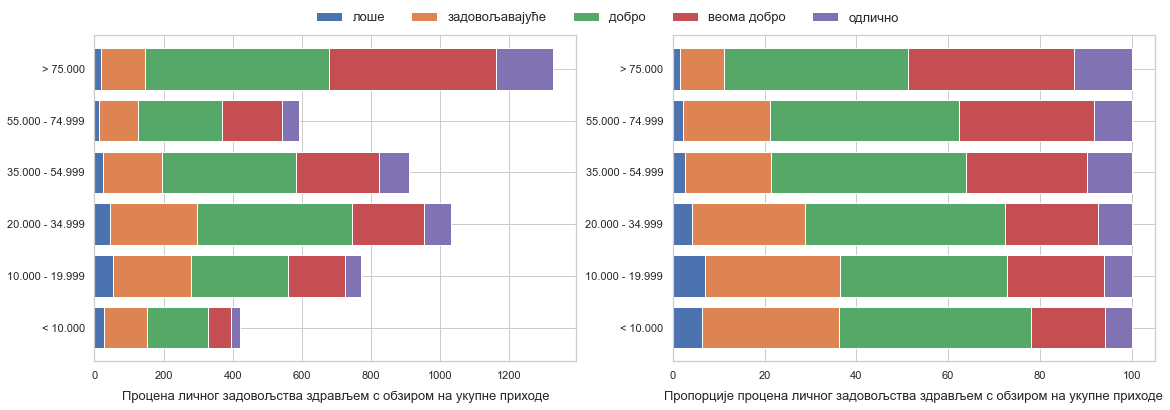

In [28]:
# Формираћемо 6 категорија висине прихода
katPrihodi = ['< 10.000', '10.000 - 19.999', '20.000 - 34.999', '35.000 - 54.999', '55.000 - 74.999', '> 75.000']
# Почетних 12 категорија ћемо смањити тако што ћемо изједначити 2 и 1, 4 и 3, 6 и 5 итд.
podaciDemUpit["INDFMIN2"].replace({2: 1, 4: 3, 6: 5, 8: 7, 10: 9, 12: 11}, inplace=True)

# Све остало радимо као и у горњем примеру
nivo = []
for stepOb in range(1, 6):
    nivo.append(podaciDemUpit[(podaciDemUpit['HSD010'] == stepOb) & (podaciDemUpit['RIDAGEYR'] > 18) & (podaciDemUpit['INDFMIN2'] < 77)]['INDFMIN2'].value_counts().sort_index())

svi = pd.concat(nivo, axis = 1)
svi.set_axis(katZdravlje, axis=1, inplace=True)

sviProc = svi.copy()
sviProc['sum'] = sviProc.iloc[:,0:5].sum(axis=1)
for stepOb in range(0, 5):
    sviProc.iloc[:,stepOb] = sviProc.iloc[:,stepOb] / sviProc['sum'] * 100
sviProc = sviProc.drop('sum', axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,6))

svi.plot.barh(edgecolor='white', width=0.8, stacked=True, ax=ax1)
ax1.set_yticklabels(katPrihodi, rotation=0, fontsize=11)
ax1.set_xlabel('Процена личног задовољства здрављем с обзиром на укупне приходе', labelpad=10, fontsize=13)
ax1.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.96), bbox_transform=plt.gcf().transFigure, fontsize=13, frameon=False)

sviProc.plot.barh(edgecolor='white', width=0.8, stacked=True, ax=ax2)
ax2.set_yticklabels(katPrihodi, rotation=0, fontsize=11)
ax2.set_xlabel('Пропорције процена личног задовољства здрављем с обзиром на укупне приходе', labelpad=10, fontsize=13)

ax2.legend_.remove()

plt.show()

<div class="alert alert-block alert-info"><img src="slike/zad.png" align="left"/>Да ли горњи графикон упућује на закључак да су особе које живе у домаћинству са већим укупним приходима уједно и задовољније својим здравственим стањем?</div> 

<details>    
<summary>
    Прикажи одговор
</summary>
Могло би се рећи. Удео одговора 1 и 2 већи је код особа које живе у домаћинствима са мањим укупним приходима. Најуочљивије разлике су оне у пропорцијама одговора 2 и 4 међу испитаницима различитог материјалног статуса. 

**Од чега зависи задовољство животом?**

Реч „зависи“ у постављеном питању сугерише постојање узрочно-последичне везе између феномена. Утврђивање постојања овог типа везе је увек превелик ризик и изазов за истраживача, јер подразумева потребу да се контролишу све варијабле које такође могу да буду узроци. На пример, не би требало да тврдимо да степен образовања *утиче* на задовољство личним здрављем. Иако смо уочили да постоји нека правилност, односно повезаност међу овим појавама, могуће је да су обе појаве повезане и са неком трећом варијаблом. Материјални статус очигледно игра важну улогу у одржавању, или барем у перцепцији здравственог стања испитаника, па тако и општег задовољства животом. Уочили смо да важну компоненту тог задовољства чине и партнерски односи, јер особе које имају партнера испољавају мање симптома депресивности на упитнику.  